In [2]:
# %pip install requests beautifulsoup4
# %pip install lambeq
# %pip install pytket-qiskit

In [3]:
import os
import re
import warnings
import requests
import json
from bs4 import BeautifulSoup
import time
import numpy as np
import ast

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [4]:
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

Web-scraping

In [6]:

url_list = ["https://www.backmarket.co.uk/en-gb/p/iphone-12-64-gb-black-unlocked/ec0b1d0d-251d-456e-bcd6-978be85e25d6#l=12",
            "https://www.backmarket.co.uk/en-gb/p/iphone-12-mini-64-gb-productred-unlocked/d9eb0d56-3928-41b4-94ea-0d3f4d0a0744#l=12",
            "https://www.backmarket.co.uk/en-gb/p/iphone-13-128-gb-unlocked/ef5660d2-6883-4b81-b47d-86e5720687ef#l=12",
            "https://www.backmarket.co.uk/en-gb/p/gb/9180e46c-fa2b-4b67-a2b3-0f83e734cc34#l=12",
            "https://www.backmarket.co.uk/en-gb/p/iphone-14-128-gb-yellow-unlocked/93301d87-c54c-4239-897b-f2bd6cd0c505#l=10",
            "https://www.backmarket.co.uk/en-gb/p/airpods-pro-with-magsafe-charging-case-white/0900e1dc-f9c4-4646-b62e-43bc66335110#l=10",
            "https://www.backmarket.co.uk/en-gb/p/airpods-max-space-gray/c11acd0f-6d26-4000-8e10-b96557e153c5#l=10",
           "https://www.backmarket.co.uk/en-gb/r/p/bb131345-13a1-4c0a-97b0-5084b27692cd?productName=Case%20iPhone%20SE%20%282022%2F2020%29%2F8%2F7%20and%202%20protective%20screens%20-%20Recycled%20plastic%20-%20Transparent&rate_min=1&rate_max=1.9"]

for url in url_list:
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
    }

    time.sleep(3)

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        reviews = []
        review_elements = soup.find_all("div", class_="relative mt-7")

        for review_element in review_elements:
            review_text = review_element.find("span", class_="body-1-light text-grey-500 whitespace-pre-line").text.strip()
            star_element = soup.find("span", class_="ml-1 text-primary body-2-bold").text.strip()[0]
            if round(float(star_element)) > 3:
                val_review = 1
            else:
                val_review = 0

            review_lines = [line.strip() for line in review_text.splitlines() if line.strip()]
            cleaned_review_text = '\n'.join(review_lines)
            reviews.append({val_review: cleaned_review_text})

        with open("data/output/backmarket_reviews.txt", "a", encoding="utf-8") as txt_file:
            for review in reviews:
                # txt_file.write(f'({review[0]}, {review[1]})\n')
                txt_file.write(f'{review}\n')

        print("Reviews have been scraped and saved to output/backmarket_reviews.txt.")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")


Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.
Reviews have been scraped and saved to output/backmarket_reviews.txt.


Split data to train and test

In [10]:
with open("data/output/backmarket_reviews_filtr.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[:35]

with open("data/output/backmarket_reviews_train.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [11]:
with open("data/output/backmarket_reviews_filtr.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[36:50]

with open("data/output/backmarket_reviews_test.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [70]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename, 'r', encoding="utf-8") as f:
        lines = f.readlines()
        for line in lines:
            res_dict = ast.literal_eval(line)
            for key, values in res_dict.items():
                labels.append([int(key), 1-int(key)])
                cleaned_review_text = re.sub(r"[^a-zA-Z0-9\s\'.!?]", '', res_dict[key].strip())
                sentences.append(cleaned_review_text)

    return labels, sentences


train_labels, train_data = read_data('data/output/backmarket_reviews_train.txt')
val_labels, val_data = read_data('data/output/backmarket_reviews_test.txt')

In [71]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    EPOCHS = 1

In [72]:
train_data[:2]

['Absolutely chuffed with this order!', 'I am more than happy.']

In [73]:
train_labels[:2]

[[1, 0], [1, 0]]

In [74]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'),verbose='progress')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/9 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/35 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/35 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/4 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/14 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/14 [00:00<?, ?it/s]

In [75]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

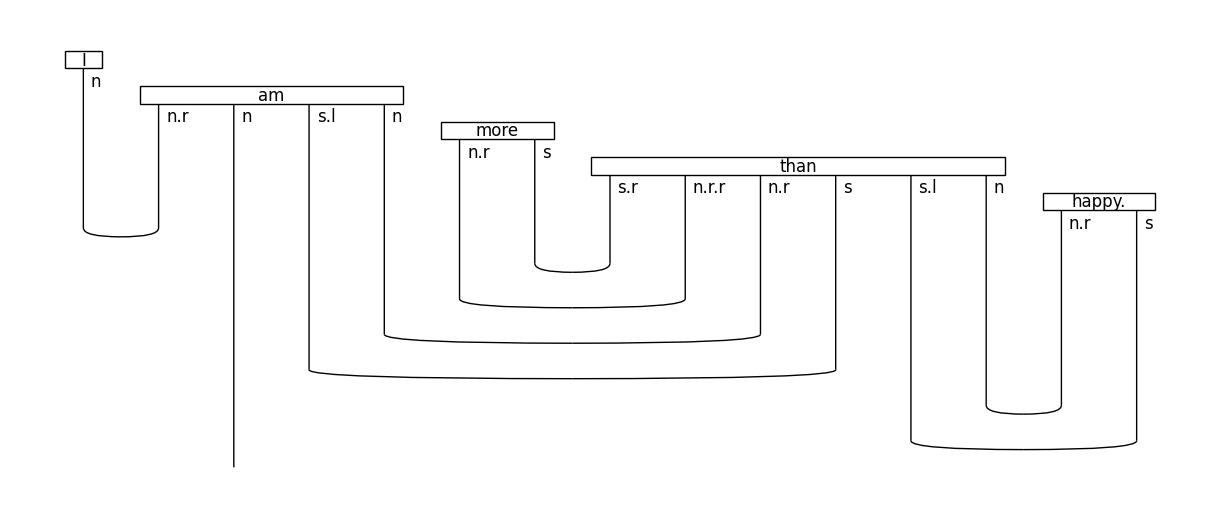

In [76]:
train_diagrams[0].draw(figsize=(12, 5), fontsize=12)

In [77]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

atomic_types = {
    AtomicType.NOUN: 1,
    AtomicType.SENTENCE: 0
}

ansatz = IQPAnsatz(atomic_types, n_layers=1, n_single_qubit_params=3)

train_circuits = []
val_circuits = []

for i, diagram in enumerate(train_diagrams):
    try:
        train_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in train_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")

for i, diagram in enumerate(val_diagrams):
    try:
        val_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in val_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")

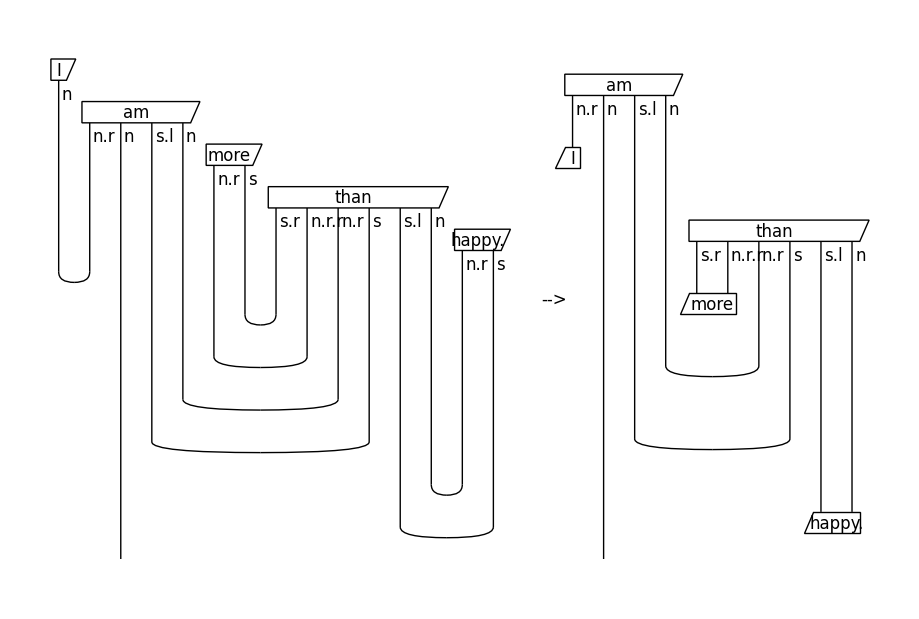

In [78]:
from discopy.drawing import Equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

Equation(original_diagram, removed_cups_diagram, symbol='-->').draw(figsize=(9, 6), asymmetry=0.3, fontsize=12)

In [79]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [80]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [81]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

In [82]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [83]:
trainer.fit(train_dataset, val_dataset, early_stopping_interval=10)

Epoch 1:    train/loss: 3.1284   valid/loss: 2.3606   train/acc: 0.4200   valid/acc: 0.5000
Epoch 2:    train/loss: 2.4367   valid/loss: 2.5038   train/acc: 0.5400   valid/acc: 0.4231
Epoch 3:    train/loss: 0.9332   valid/loss: 2.5294   train/acc: 0.5400   valid/acc: 0.5385
Epoch 4:    train/loss: 0.7129   valid/loss: 2.6932   train/acc: 0.5200   valid/acc: 0.5385
Epoch 5:    train/loss: 5.6812   valid/loss: 2.3725   train/acc: 0.5600   valid/acc: 0.6154
Epoch 6:    train/loss: 1.2448   valid/loss: 2.2167   train/acc: 0.6000   valid/acc: 0.6923
Epoch 7:    train/loss: 0.3624   valid/loss: 2.3693   train/acc: 0.6400   valid/acc: 0.5385
Epoch 8:    train/loss: 0.6383   valid/loss: 2.4125   train/acc: 0.6600   valid/acc: 0.5385
Epoch 9:    train/loss: 2.5657   valid/loss: 2.4869   train/acc: 0.5000   valid/acc: 0.5385
Epoch 10:   train/loss: 3.9178   valid/loss: 2.5502   train/acc: 0.7400   valid/acc: 0.5385
Epoch 11:   train/loss: 2.5392   valid/loss: 2.5896   train/acc: 0.5000   valid/

Validation accuracy: 0.5384615384615384


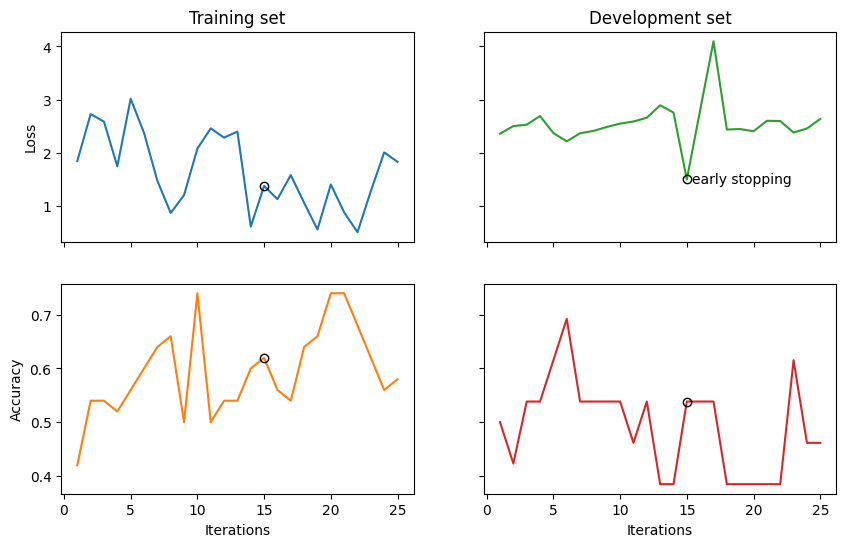

In [84]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())